In [1]:
# Libraries:
library(tidyverse)
library(readr)
library(dplyr)
library(ggplot2)
library(cowplot)
library(GGally)
library(rsample)
library(glmnet)
library(broom)
library(pROC)
library(latex2exp)
library(tidymodels)
library(repr)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(modelr)
library(caret)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

## 2) Methods: Plan

To approach our question, we will conduct **logistic regression** as our response is a binary variable. This will be fit for a **predictive model**. However, there are a few key steps we need to take before conducting any tests. 

As seen from the EDA and Correlation Heatmap above, we have a wide selection of predictors to select from. We intend to use these predictors in order to explain our overarching question about employee retention, but a challenging obstacle is presented beforehand: how can we improve our prediction accuracy, and what can we do in order to increase model interpretibility? There may be variables that aren't relevant to our analysis, and including them would only increase variance. Let us constrain our project to only variables that are deemed relevant to our topic. To do so, we will split our dataset and perform **LASSO Regularization** to shrink our model before performing regression. This is our **Feature Selection**, and will be shown below. Afterwards, we will test our model and further discuss the findings.



## Feature Selection:

Throughout this section, we will be discussing how and why we chose our covariates. The goal for our LASSO regularization is to find the optimum number of predictors that produces the highest average AUC. In doing so, the lasso method is able to reduce the number of predictors we will use in our model by shrinking their coefficients to zero during optimization, which will help improve our models interpretibility. Furthermore, this will hopefully coincide with our correlation heatmap from above and we will approach this in our discussion. 

Cross-fold validation can be used initially to select the number of parameters as it reduces the risk of overfitting, tunes the parameters and selects the ones that generalizes well to new data, and reduces variability.

Now we will split our data into training and testing, and prepare the training data for LASSO. We will do this at a 60/40 ratio for predictive purposes.

In [10]:
# Main Developer: Andy Hong
set.seed(1234)
## load data
employee  <- read.csv("Employee.csv")

## split into training and testing
split <- initial_split(employee, prop = 0.6)

employee_training <- training(split)
employee_testing <- testing(split)

LASSO uses the `glmnet` function which only works on model matrixes, so we will use `model.matrix` to prepare our data. We will also remove the (Intercept) column, which is filled with ones and not relevant to our preparation.


In [11]:
# Main Developer: Andy Hong
set.seed(1234)
model_matrix_X_train <- 
    model.matrix(LeaveOrNot ~ ., employee_training)[,-1]

matrix_Y_train <- 
    as.matrix(employee_training$LeaveOrNot, ncol = 1)

With our prepared training data, we can use `cv.glmnet` to find the optimal $\lambda$ value that provides the largest average AUC. 

We will use 5-fold cross validation for this model.

In [12]:
# Main Developer: Andy Hong
set.seed(1234)
employee_cv_lambda_LASSO <- 
  cv.glmnet(
  x = model_matrix_X_train, y = matrix_Y_train,
  alpha = 1,
  family = 'binomial',
  type.measure = 'auc',
  nfolds = 5)

employee_cv_lambda_LASSO


Call:  cv.glmnet(x = model_matrix_X_train, y = matrix_Y_train, type.measure = "auc",      nfolds = 5, alpha = 1, family = "binomial") 

Measure: AUC 

      Lambda Index Measure       SE Nonzero
min 0.001012    51  0.7383 0.008530      10
1se 0.019858    19  0.7303 0.005709       8

To help interpreset the data above, lets first graph this using the plot() function


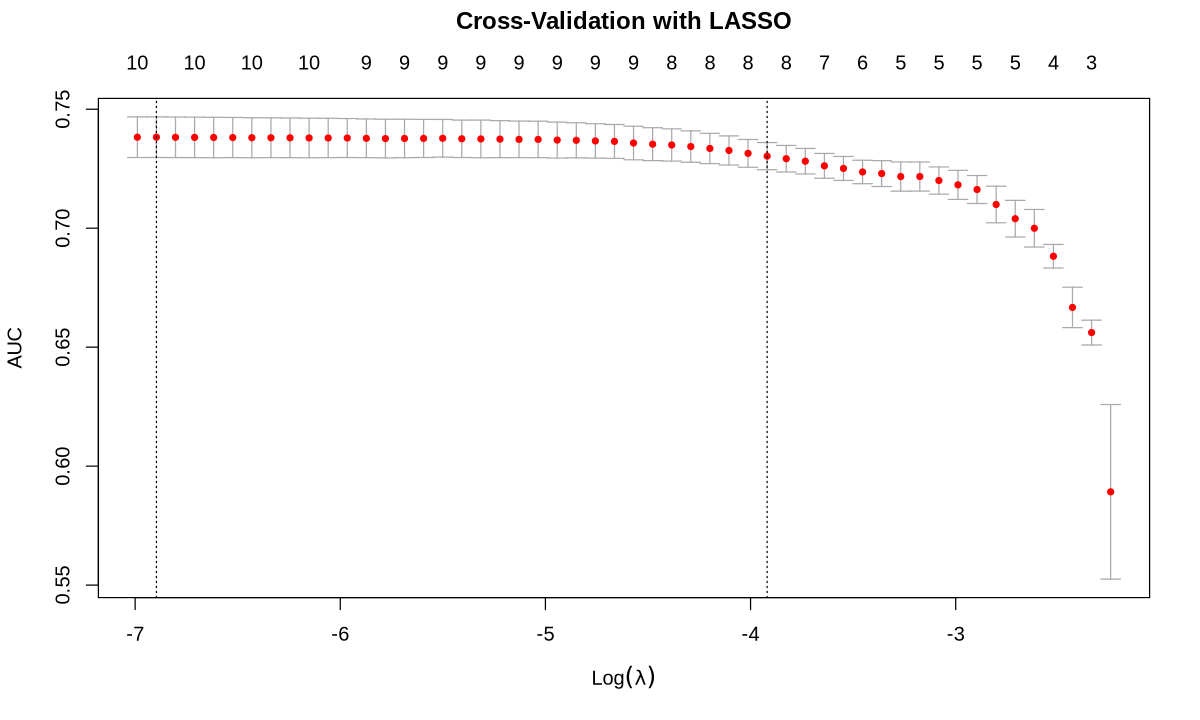

In [13]:
# Main Developer: Andy Hong
set.seed(1234)
options(repr.plot.width = 10, repr.plot.height = 6)

plot(employee_cv_lambda_LASSO, main = "Cross-Validation with LASSO\n\n")

The two vertical liness from `cv.glmnet()` correspond to two values of $\lambda$:

- $\hat{\lambda}_{\text{min}}$ which provides the maximum average AUC out of the whole sequence for $\lambda$.


- $\hat{\lambda}_{\text{1SE}}$ is the highest $\lambda$ for which the model has an average AUC within one standard error of the maximum.

The numbers across the top of the graph indicate the number of predictors (value of $\lambda$) used. For our case, we will use $\hat{\lambda}_{\text{1SE}}$, as our goal is to improve model interpretibility and the most important set of predictors is more useful for feature selection.

We will extract this value of $\lambda$.

In [14]:
# Main Developer: Andy Hong
set.seed(1234)
employee_cv_lambda1se_LASSO_value <- round(employee_cv_lambda_LASSO$lambda.1se, 4)
employee_cv_lambda1se_LASSO_value

[1] 0.0199

Now we can use this value for LASSO to determine which predictors to select using `glmnet`.

In [15]:
# Main Developer: Andy Hong
set.seed(1234)
employee_LASSO <- glmnet(
x = model_matrix_X_train, y = matrix_Y_train,
  alpha = 1,
  family = 'binomial',
  lambda = employee_cv_lambda1se_LASSO_value
)

coef(employee_LASSO)


11 x 1 sparse Matrix of class "dgCMatrix"
                                     s0
(Intercept)               -2.674429e+02
EducationMasters           5.427369e-01
EducationPHD               .           
JoiningYear                1.329476e-01
CityNew Delhi             -1.320608e-01
CityPune                   6.495482e-01
PaymentTier               -3.057490e-01
Age                       -6.121358e-03
GenderMale                -6.759426e-01
EverBenchedYes             2.068417e-01
ExperienceInCurrentDomain  .           

Interesting! We are given `EducationMasters`, `JoiningYear`, `CityNew Delhi`, `CityPune`, `PaymentTier`, `Age`, `GenderMale`,  and `EverBenchedYes` as our parameters. It seems that LASSO chose subsets of our variables (`EverBenchedYes` rather than just `EverBenched`) for our predictors. 

For simplicity and once again, model interpretability, we will use the base predictors `Education`, `JoiningYear`, `City`, `PaymnetTier`, `Age`, and `EverBenched`. 

We will choose to exclude gender as ...

## Testing the Model

Our last step is to test our model. To do this, we will create our **logistic model** based off the covariates found above fit off the training data. Then, we will use the trained model to predict the testing data, and we will display this using a confusion matrix.

In [16]:
# Main Developer: Andy Hong
set.seed(1234)

employee_logistic_model <- glm(LeaveOrNot ~ Education + JoiningYear + City + PaymentTier + Age + EverBenched, 
                               data = employee_training, family = 'binomial')

employee_pred_class <- round(predict(employee_logistic_model, newdata = employee_testing, type = 'response'))

employee_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(employee_pred_class),
    reference = as.factor(employee_testing$LeaveOrNot),
    positive = '1'
)

employee_confusion_matrix

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1067  420
         1  163  212
                                          
               Accuracy : 0.6869          
                 95% CI : (0.6653, 0.7079)
    No Information Rate : 0.6606          
    P-Value [Acc > NIR] : 0.008504        
                                          
                  Kappa : 0.2252          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.3354          
            Specificity : 0.8675          
         Pos Pred Value : 0.5653          
         Neg Pred Value : 0.7176          
             Prevalence : 0.3394          
         Detection Rate : 0.1139          
   Detection Prevalence : 0.2014          
      Balanced Accuracy : 0.6015          
                                          
       'Positive' Class : 1               
                        

In [17]:
# set.seed(1234)
# model_matrix_X_test <- 
#     model.matrix(LeaveOrNot ~ .,
#                  data = employee_testing)[, -1]

# ROC_lasso <- 
#     roc(
#         response = employee_testing$LeaveOrNot,
#         predictor = predict(employee_LASSO,
#                      newx = model_matrix_X_test,)[,"s0"] ) 

# ROC_lasso